In [1]:
import uproot as up
from hist import Hist, Stack
import numpy as np
import os
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from pathlib import Path
from collections import namedtuple
from itertools import combinations
sns.set_style('white')
sns.set_context('poster')

In [2]:
outdir = Path("/g/g92/samuele/nEXO/sensitivity/work/SensitivityPaper2020_scripts/SiteSelectionStudy/results/")

In [3]:
Scenario = namedtuple('scenario', ['name', 'dir', 'muons_per_file'])

case_list = [Scenario('LNGS',
                      # Path("/p/lustre2/nexouser/data/site_selection/LNGS_Shielding/large_run/cosmogenics_processed/data/"),
                      Path("/p/lustre2/nexouser/data/site_selection/LNGS_Shielding/large_run/cosmogenics_reprocessed"),
                      50e3),
             Scenario('SNOLAB',
                      # Path("/p/lustre2/nexouser/data/site_selection/SNOLAB_Shielding_25TeV_v3/cosmo_analysis_data/data/"),
                      Path("/p/lustre2/nexouser/data/site_selection/SNOLAB_Shielding_large/reprocessed_after_bug_fix"),
                      50e3)]

In [4]:
# branches = ['Xe137Count','Cu64Count','Cu66Count','F20Count','H2Count']
# events_filter = '(Xe137Count >0) | (Cu64Count >0) | (Cu66Count >0)'
isotopes = ['Xe137', 'Cu66', 'Cu64', 'Cu62', 'F20', 'H2', 'I134', 'I130', 'I132', 'I135', 'I136', 'I137']
isotope_pairs = list(combinations(isotopes, 2))
branches = [f'{iso}Count' for iso in isotopes]
events_filter = " | ".join([f'({iso}Count >0)' for iso in isotopes])

In [5]:
%%time
# If interested in processing a subset of the data
# set `limit` to the number of files to process i
limit = None

file_list_len = {}
for case in case_list:
    print(f"Loading data for {case.name}...")
    
    # if case.name == "SNOLAB":
        # file_list = list(x for x in case.dir.rglob('*.root') if x.is_file() and x.stat().st_size>1.4e9)
    # else:
    file_list = list(x for x in case.dir.rglob('*.root') if x.is_file())        
    print(f'\tFiles available: {len(file_list)}')
    
    if limit and (len(file_list) > limit):
        file_list = file_list[:limit]
    file_list_len[case.name] = len(file_list)
    
    upfile = up.open(file_list[0], object_cache=2000, array_cache='2000 MB')
    tree = upfile["cosmoTree"]
    # print(tree.keys())
    print(f'\tEntries in the first file: {tree.num_entries}')
    
    events = ak.to_dataframe(up.concatenate(file_list, 
                                        branches, events_filter, allow_missing=True,
                                        library='ak'))    
    print(events.head(),'\n')
    
    events.to_pickle(outdir / f"{case.name}_activation_products.pkl")

Loading data for LNGS...
	Files available: 2014
	Entries in the first file: 49999
       Xe137Count  Cu66Count  Cu64Count  Cu62Count  F20Count  H2Count  \
entry                                                                   
0               0          0          0          0         0        1   
1               0          0          0          0         0        1   
2               0          0          0          0         0        1   
3               0          0          0          0         0        1   
4               0          0          0          0         1        0   

       I134Count  I130Count  I132Count  I135Count  I136Count  I137Count  
entry                                                                    
0              0          0          0          0          0          0  
1              0          0          0          0          0          0  
2              0          0          0          0          0          0  
3              0          0         

In [6]:
# events = tree.arrays(branches, events_filter, library='pd')
# for array in up.iterate(file_list[1:], branches, events_filter, library='pd'):
    # events.append(array)

In [7]:
# for file in file_list[1:]:
    # with up.open(folder_path / file_name, object_cache=2000, array_cache='2000 MB') as upfile:
        # print(file)
        # tree = upfile["cosmoTree"]
        # events.append(tree.arrays(branches, events_filter, library='pd'))

In [8]:
events_dict = {}
for case in case_list:
    events_dict[case.name] = pd.read_pickle(outdir / f"{case.name}_activation_products.pkl")

In [9]:
for case in case_list:
    events = events_dict[case.name]
    print(f'Site: {case.name}')
    n_muons = case.muons_per_file * file_list_len[case.name]
    print(f'  Muons simulated: {n_muons:.0f}')
    # prob = events[(events.Xe137Count >0) | (events.Cu64Count >0) | (events.Cu66Count >0)]['Xe137Count'].count()/n_muons
    # print(f"  Fractions of muons with non-zero captures: {prob:.2e} +/- {np.sqrt(prob*(1-prob)/n_muons):.2e}")
    for iso in isotopes:
        prob = events[(events[f'{iso}Count'] > 0)][f'{iso}Count'].count()/n_muons
        print(f"  Fraction of muons producing {iso}: {prob:.2e} +/- {np.sqrt(prob*(1-prob)/n_muons):.2e}")

Site: LNGS
  Muons simulated: 100700000
  Fraction of muons producing Xe137: 3.84e-04 +/- 1.95e-06
  Fraction of muons producing Cu66: 1.49e-04 +/- 1.22e-06
  Fraction of muons producing Cu64: 4.60e-04 +/- 2.14e-06
  Fraction of muons producing Cu62: 2.42e-05 +/- 4.90e-07
  Fraction of muons producing F20: 9.11e-04 +/- 3.01e-06
  Fraction of muons producing H2: 3.80e-03 +/- 6.13e-06
  Fraction of muons producing I134: 1.95e-05 +/- 4.40e-07
  Fraction of muons producing I130: 1.61e-05 +/- 4.00e-07
  Fraction of muons producing I132: 2.17e-05 +/- 4.65e-07
  Fraction of muons producing I135: 2.05e-05 +/- 4.51e-07
  Fraction of muons producing I136: 6.04e-06 +/- 2.45e-07
  Fraction of muons producing I137: 0.00e+00 +/- 0.00e+00
Site: SNOLAB
  Muons simulated: 7900000
  Fraction of muons producing Xe137: 4.25e-04 +/- 7.33e-06
  Fraction of muons producing Cu66: 1.62e-04 +/- 4.53e-06
  Fraction of muons producing Cu64: 5.16e-04 +/- 8.08e-06
  Fraction of muons producing Cu62: 2.80e-05 +/- 1.

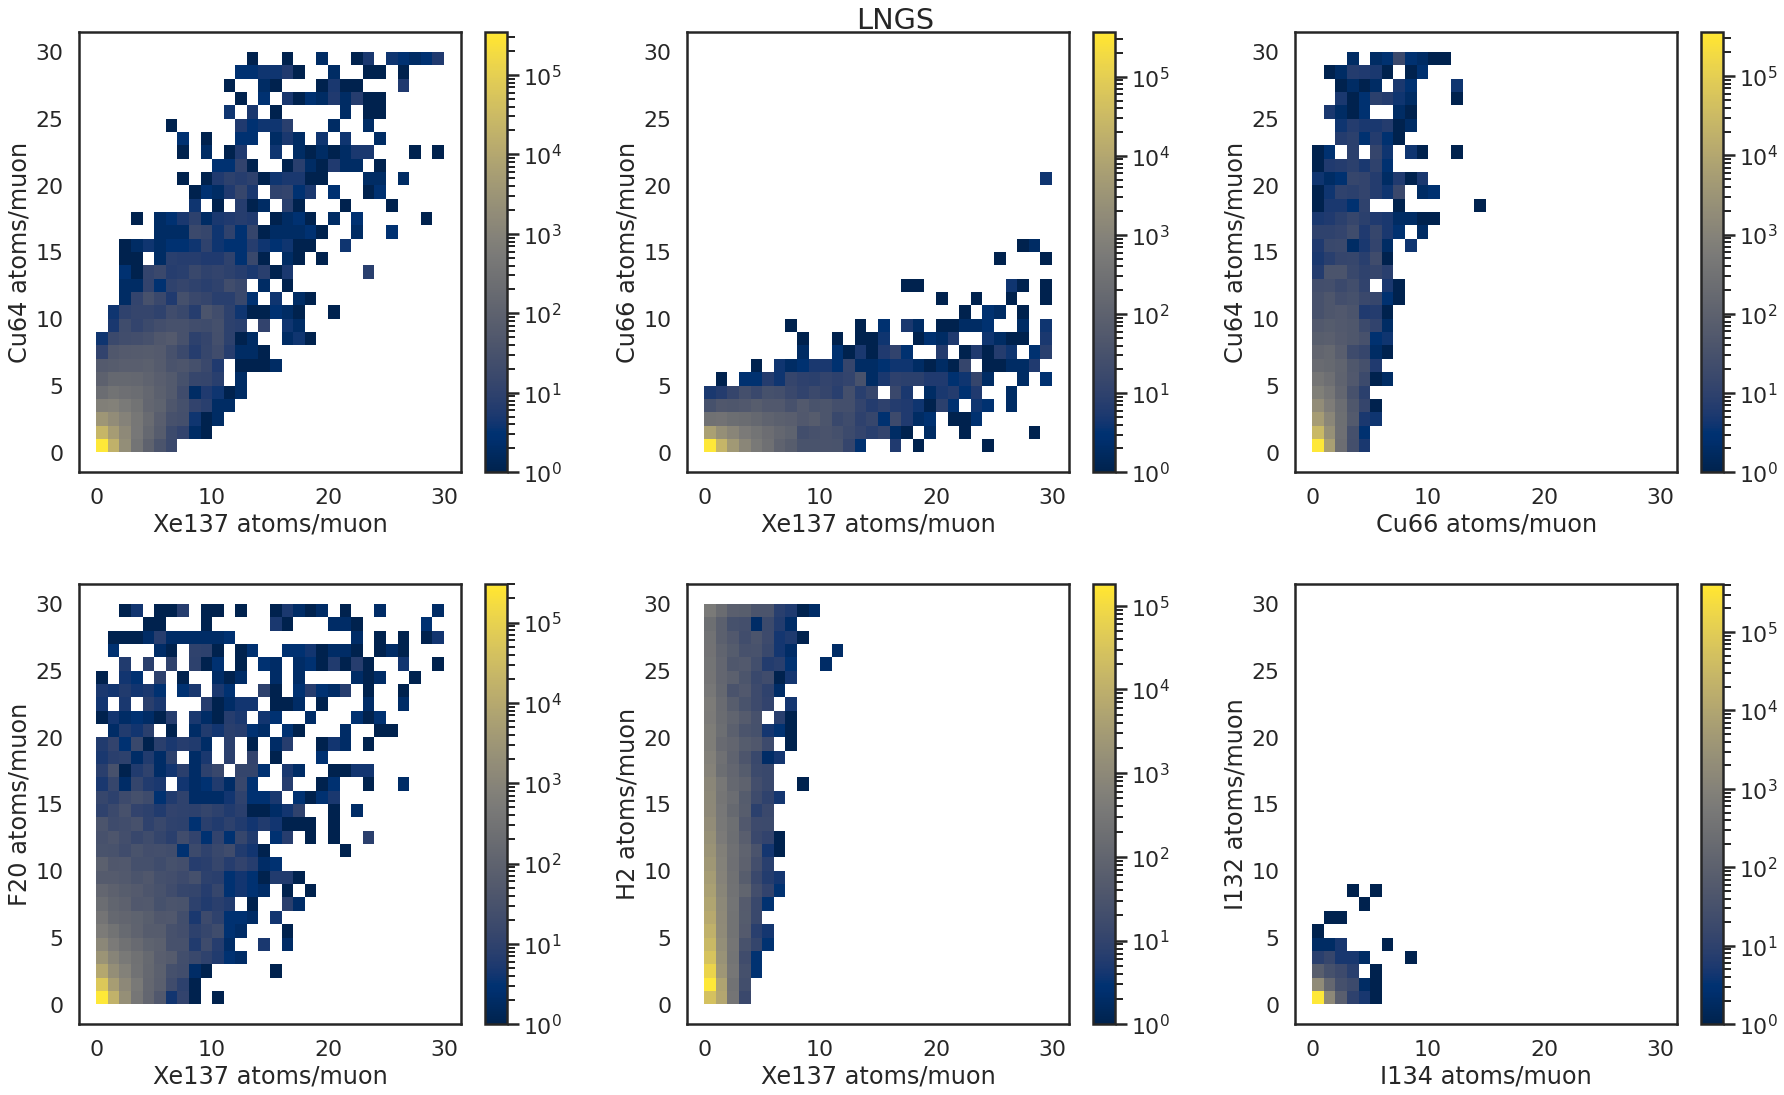

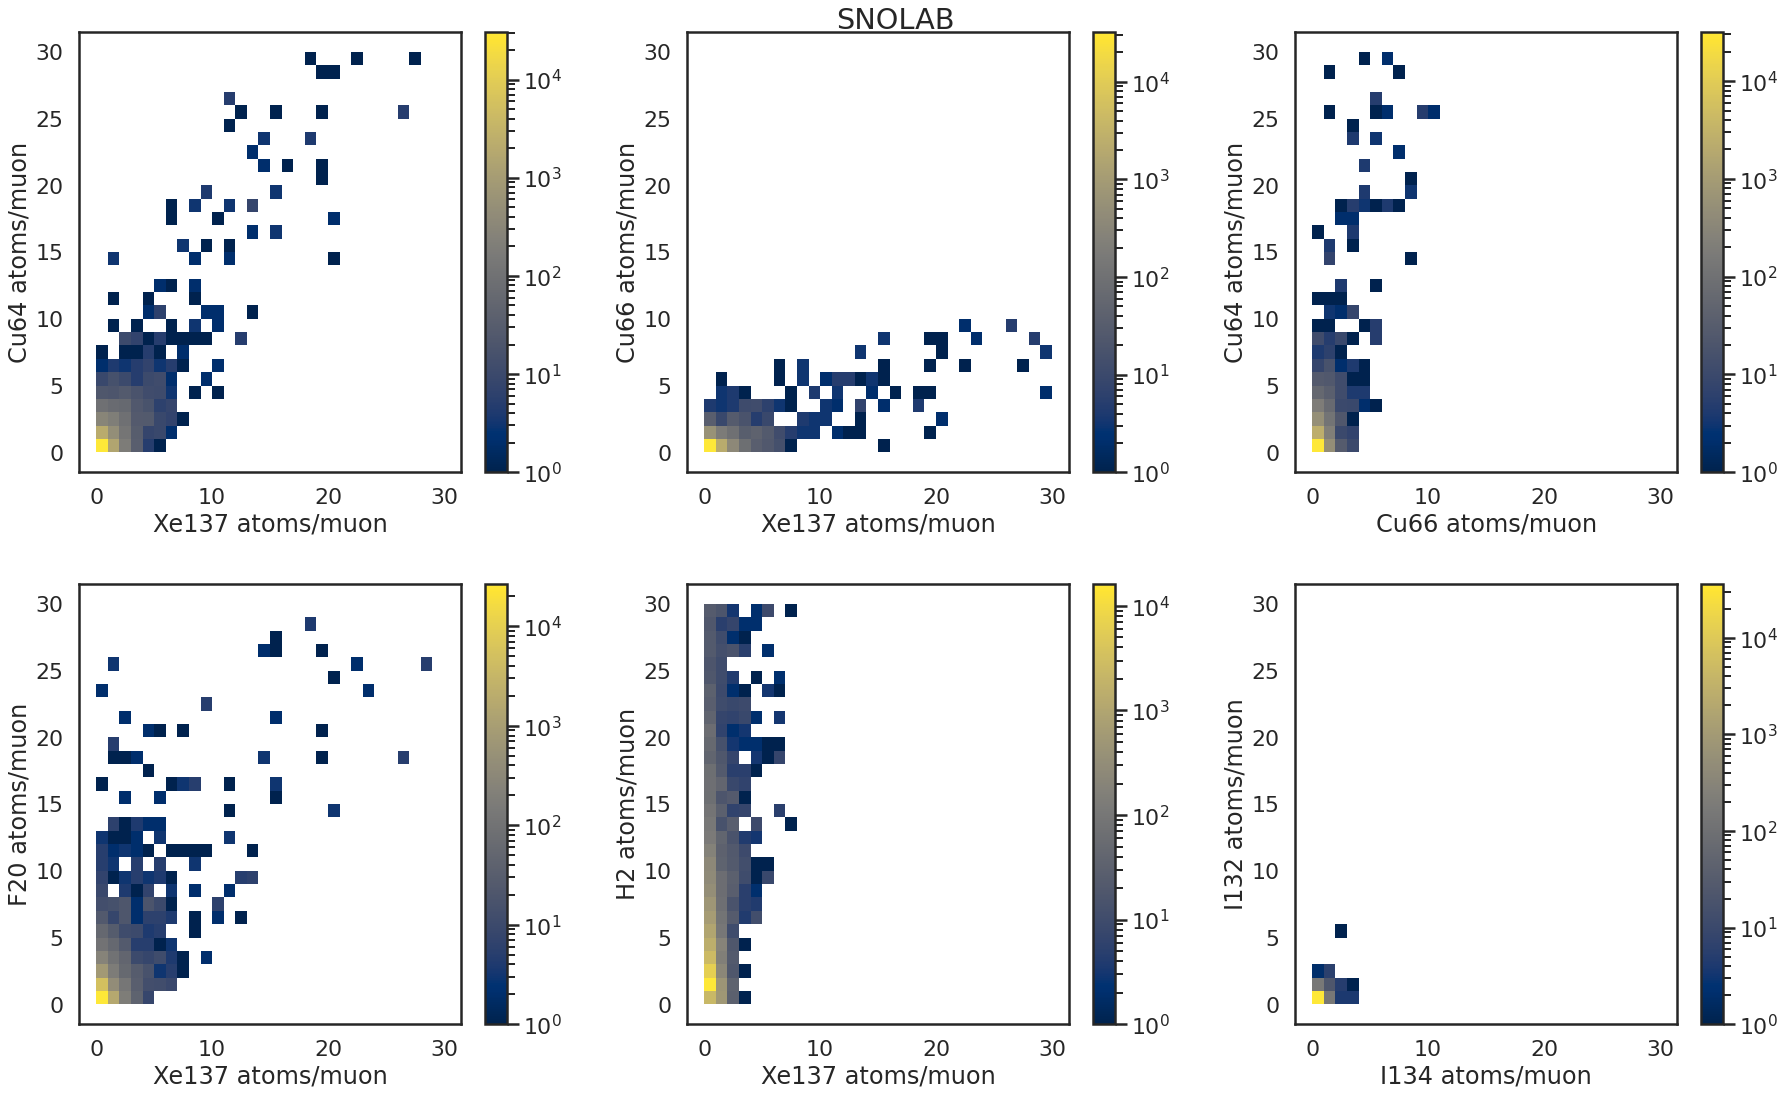

In [10]:
isotope_pairs = [('Xe137', 'Cu64'), 
                 ('Xe137', 'Cu66'),
                 ('Cu66', 'Cu64'),
                 ('Xe137', 'F20'),
                 ('Xe137', 'H2'),
                 ('I134', 'I132')]
for name, events in events_dict.items():
    fig, ax = plt.subplots(2, 3, figsize=(26, 16))
    ax = ax.reshape(6, 1)
    for i, (iso1, iso2) in enumerate(isotope_pairs):
        p = sns.histplot(events, 
                         x=f'{iso1}Count', y=f'{iso2}Count', cmap="cividis",  
                         cbar = True, binwidth=1, binrange=((0,30),(0,30)),
                         norm=colors.LogNorm(), vmin=None, vmax=None, ax=ax[i,0])
        p.set(xlabel=f'{iso1} atoms/muon')
        p.set(ylabel=f'{iso2} atoms/muon')
        # p.set(title=name)
    fig.tight_layout(pad=2.0)
    fig.suptitle(name)
    fig.savefig(outdir / f"{name}_activation_correlations.png", bbox_inches="tight", 
                transparent=False, facecolor='white')

LNGS
LNGS Xe137 Multiplicity:
	 Mean: 2.17 +/- 0.02
	 StDev: 4.34
	 Median: 1.0
LNGS Cu66 Multiplicity:
	 Mean: 1.55 +/- 0.01
	 StDev: 1.82
	 Median: 1.0
LNGS Cu64 Multiplicity:
	 Mean: 2.32 +/- 0.02
	 StDev: 4.94
	 Median: 1.0
LNGS Cu62 Multiplicity:
	 Mean: 1.04 +/- 0.00
	 StDev: 0.23
	 Median: 1.0
LNGS F20 Multiplicity:
	 Mean: 2.13 +/- 0.01
	 StDev: 4.37
	 Median: 1.0
LNGS H2 Multiplicity:
	 Mean: 5.25 +/- 0.04
	 StDev: 22.60
	 Median: 2.0
LNGS I134 Multiplicity:
	 Mean: 1.15 +/- 0.01
	 StDev: 0.50
	 Median: 1.0
LNGS I130 Multiplicity:
	 Mean: 1.11 +/- 0.01
	 StDev: 0.42
	 Median: 1.0
LNGS I132 Multiplicity:
	 Mean: 1.12 +/- 0.01
	 StDev: 0.49
	 Median: 1.0
LNGS I135 Multiplicity:
	 Mean: 1.15 +/- 0.01
	 StDev: 0.56
	 Median: 1.0
LNGS I136 Multiplicity:
	 Mean: 1.01 +/- 0.00
	 StDev: 0.12
	 Median: 1.0
SNOLAB
SNOLAB Xe137 Multiplicity:
	 Mean: 2.06 +/- 0.07
	 StDev: 3.77
	 Median: 1.0
SNOLAB Cu66 Multiplicity:
	 Mean: 1.58 +/- 0.05
	 StDev: 1.72
	 Median: 1.0
SNOLAB Cu64 Multiplici

/var/tmp/samuele/ipykernel_72940/3500516082.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i,0].set_yscale('log')


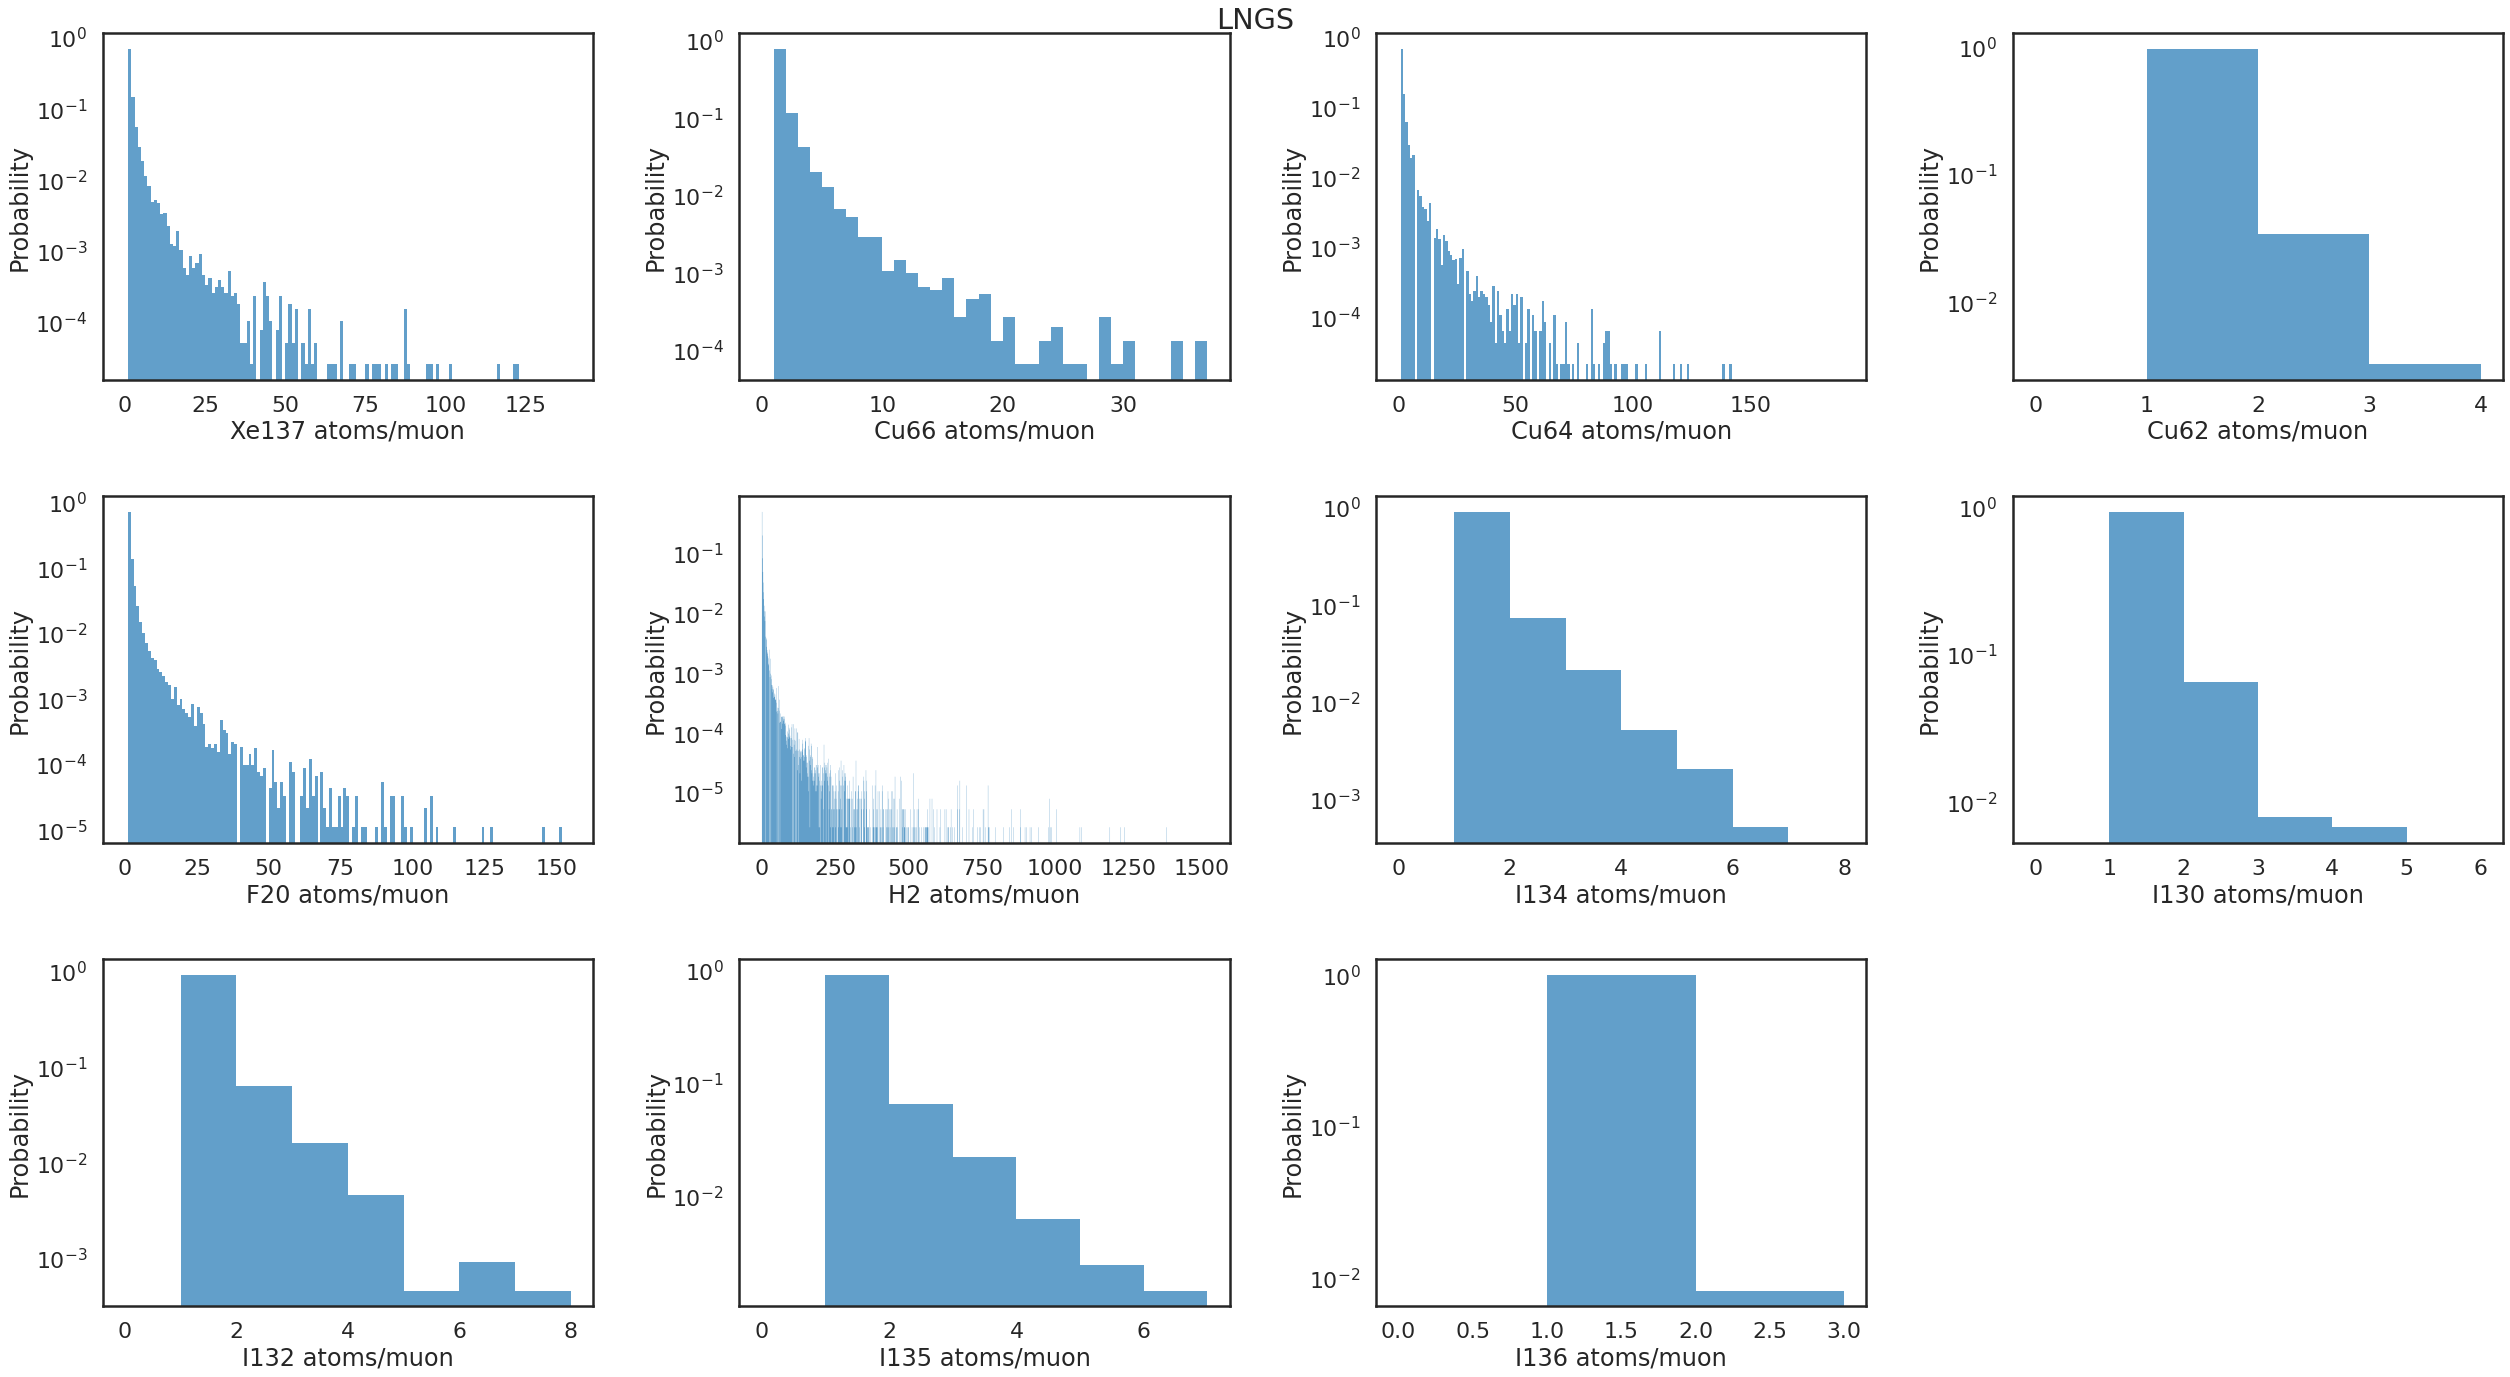

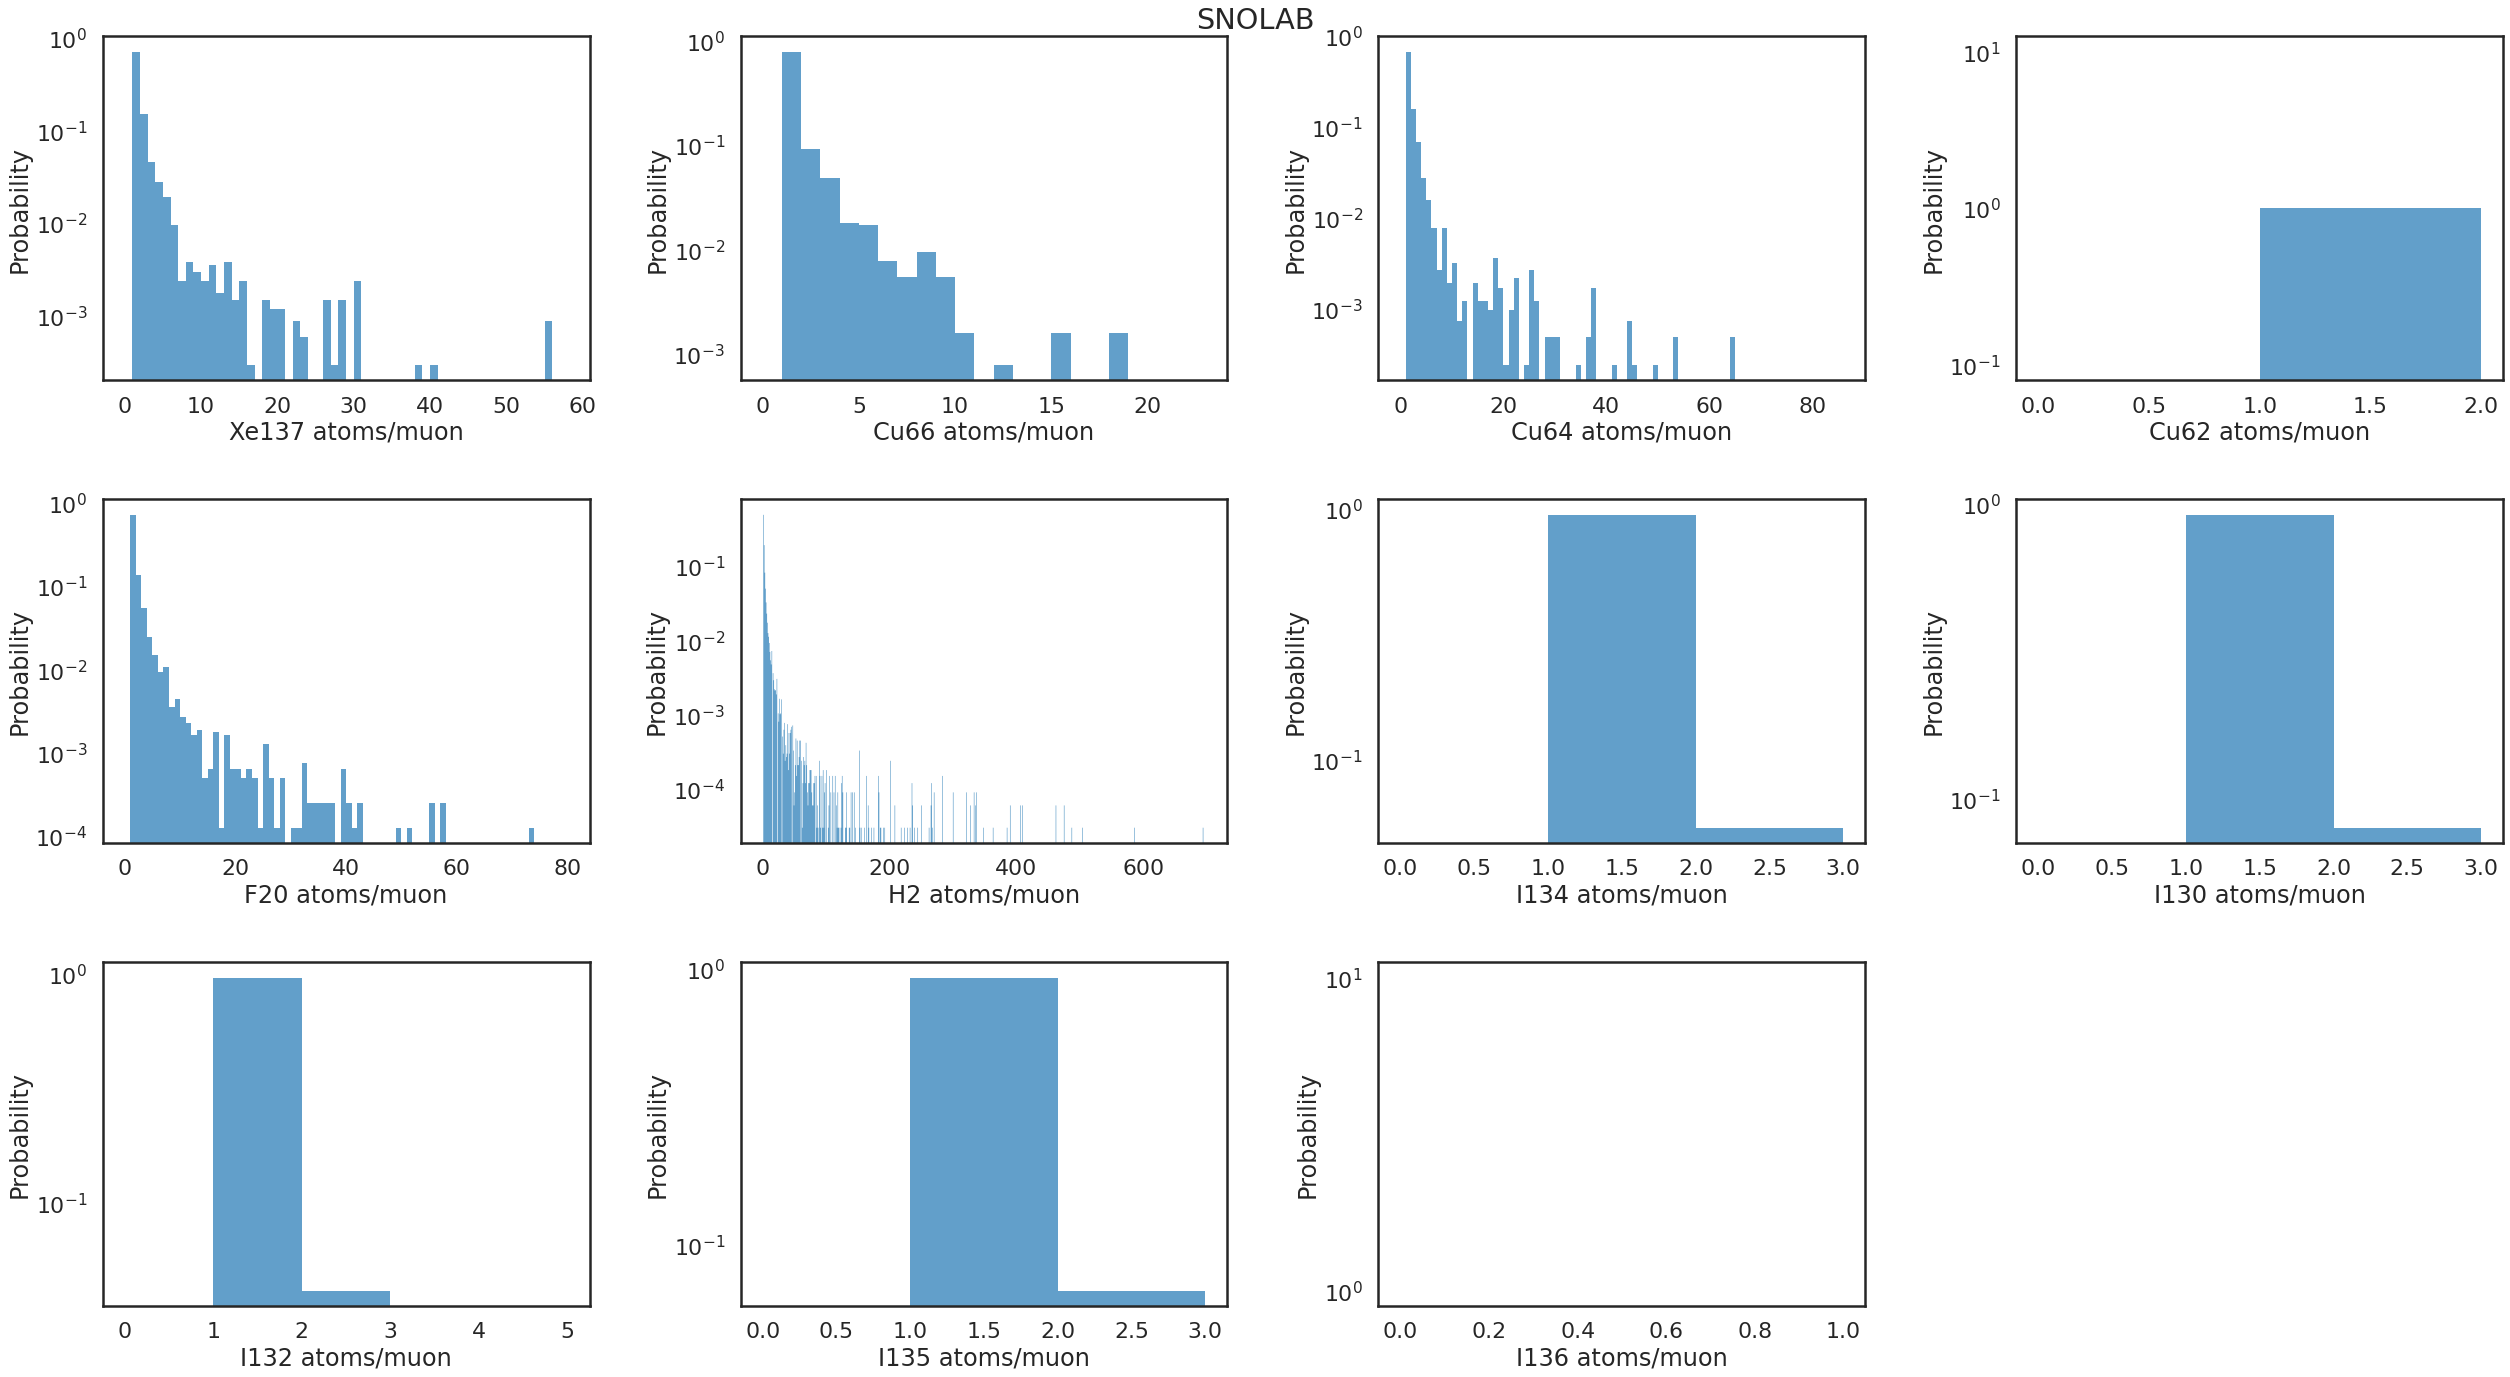

In [11]:
for case in case_list:
    rows = 3
    cols = int(len(isotopes)/rows)
    fig, ax = plt.subplots(rows, cols, figsize=(36, 20))
    ax = ax.reshape(rows*cols, 1)
    print(case.name)
    for i, iso in enumerate(isotopes):
        hist_dict = {} 
        name = case.name
        events = events_dict[name]
        n_muons = case.muons_per_file * file_list_len[case.name]
        max_v = events[(events[f'{iso}Count'] > 0)][f'{iso}Count'].max()
        if np.isnan(max_v):
            ax[i,0].axis('off')
        else:
            hist_dict[name] = Hist.new.Regular(max_v, 0, max_v).Double()
            hist_dict[name].fill(events[events[f'{iso}Count']>0][f'{iso}Count'])
            hist_dict[name][:] = hist_dict[name].density()
            print(f'{name} {iso} Multiplicity:')
            mean = events[events[f'{iso}Count']>0][f'{iso}Count'].mean()
            stddev = events[events[f'{iso}Count']>0][f'{iso}Count'].std()
            n = events[events[f'{iso}Count']>0][f'{iso}Count'].count()
            print(f"\t Mean: {mean:.2f} +/- {stddev/np.sqrt(n):.2f}")
            print(f"\t StDev: {stddev:.2f}")
            print(f"\t Median: {events[events[f'{iso}Count']>0][f'{iso}Count'].median()}")
            # s = Stack.from_dict(hist_dict)
            hist_dict[name].plot(histtype="fill", alpha=0.7, ax=ax[i,0])
            # ax[i,0].legend()
            ax[i,0].set_xlabel(f'{iso} atoms/muon')
            ax[i,0].set_ylabel('Probability')
            ax[i,0].set_yscale('log')
    fig.tight_layout(pad=2.0)
    fig.suptitle(case.name)
    fig.savefig(outdir / f"{case.name}_multiplicity_distr.png", bbox_inches="tight", 
                transparent=False, facecolor='white')